In [7]:
%matplotlib inline
# %matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from tools import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# plot general settings
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Functions

In [8]:
def get_diff_coeff_library(filename='../03-source/diffusion_coefficient'):
    """Return dataframe with diffusion coefficients from the experimental data
    """
    df = pd.read_pickle(filename)
    df['temperature'] = df['temperature'].replace(243, 240)
    df['transmission'] = df['transmission'].str.replace('%', '')
    df['transmission'] = df['transmission'].str.replace('nan', '100')
    df['transmission'] = df['transmission'].str.replace('~', '')
    df['transmission'] = df['transmission'].astype(float)
    
    return df

def load_npz_data(filename):
    """Loads data from npz file and return a dictionary
    """
    file = np.load(filename)
    data = {key: file[key] for key in file.files}

    return data

# Load data

Load viscosities

In [9]:
etas = viscosity()
etas#['50w%']

,temp,50w%,50v%,60v%,c1,c2,c3
0,300,0.004674,0.006357,0.011691,0.006726,0.008012,0.010947
1,290,0.006771,0.009497,0.018606,0.010106,0.012256,0.017301
2,280,0.010448,0.015197,0.032089,0.016282,0.020171,0.029595
3,270,0.017490,0.026578,0.061359,0.028708,0.036484,0.056042
4,260,0.032565,0.052163,0.134000,0.056900,0.074554,0.120980
5,250,0.069890,0.119340,0.348570,0.131720,0.179070,0.310370
6,240,0.182690,0.337190,1.149900,0.377570,0.536700,1.007000
7,230,0.635210,1.289300,5.300200,1.469200,2.204400,4.550300
8,220,3.416900,7.785200,40.015000,9.060500,14.508000,33.555000
9,210,37.846000,98.826000,657.370000,117.890000,203.600000,536.700000


Load diffusion coefficients from DLS measurements

In [10]:
DLS = load_npz_data('../03-source/DLS_diff_coeff.npz') # D in m^2/s, T in K
DLS['D'] = DLS['D']*1e12

Load experimental diffusion coefficients from ID10

In [11]:
df2 = get_diff_coeff_library()
df2

,temperature,transmission,D,dD,c
0,240,45.00,0.044803,0.000973,c1
1,240,100.00,0.058330,0.002202,c1
2,220,100.00,0.005152,0.000091,c1
3,220,45.00,0.004381,0.000073,c1
4,220,22.50,0.004355,0.000077,c1
5,240,100.00,0.004758,0.000055,c3
6,240,45.00,0.003454,0.000134,c3
7,240,22.50,0.003750,0.000246,c3
8,240,11.25,0.002887,0.000091,c3
9,250,100.00,0.140541,0.003009,c1


Sort the database

In [12]:
df2 = df2.sort_values(by='transmission', ascending=False)
df2 = df2.sort_values(by='c')

In [13]:
df2[df2['c']=='c2']

,temperature,transmission,D,dD,c
20,260,100.0,0.121895,0.002851,c2
18,250,100.0,0.047516,0.003283,c2
19,240,100.0,0.015848,0.000249,c2


Get temperatures from the database

In [14]:
Ts = df2.sort_values(by='temperature')['temperature'].unique()
Ts

array([210, 220, 230, 240, 250, 260])

Import the viscosity values for variable temperature and get the diffusion coefficient from Stockes-Einsten relation

In [16]:
# eta50w = etas['50w%'] #eta_50w_gly()
# eta50 = etas['50v%'] #eta_50v_gly()
# eta60 = etas['60v%'] #eta_60v_gly()

In [17]:
T = 210
etas[etas['temp']==T]['50v%'].values[0]

98.826

In [18]:
SE2 = pd.DataFrame(columns=['temperature', 'D_50', 'D_60'])
SE = pd.DataFrame(columns=['temperature', 'D_c1', 'D_c2', 'D_c3'])

for T in etas['temp']:
    # default uses Rh=6.6e-9 m
    row2 = {'temperature': T,  'D_50': D_coeff(T=T, eta=etas[etas['temp']==T]['50v%'].values[0]), "D_60": D_coeff(T=T, eta=etas[etas['temp']==T]['60v%'].values[0]), "D_50w": D_coeff(T=T, eta=etas[etas['temp']==T]['50w%'].values[0], Rh=6.6e-9)}
    SE2 = SE2.append(row2, ignore_index=True)
    
    row = {'temperature': T,  'D_c1': D_coeff(T=T, eta=etas[etas['temp']==T]['c1'].values[0]), "D_c2": D_coeff(T=T, eta=etas[etas['temp']==T]['c2'].values[0]), "D_c3": D_coeff(T=T, eta=etas[etas['temp']==T]['c3'].values[0], Rh=6.6e-9)}
    SE = SE.append(row, ignore_index=True)
SE

,temperature,D_c1,D_c2,D_c3
0,300.0,4.949823e-12,4.155455e-12,3.041336e-12
1,290.0,3.184615e-12,2.625956e-12,1.860223e-12
2,280.0,1.908484e-12,1.540525e-12,1.049972e-12
3,270.0,1.043756e-12,8.212957e-13,5.346731e-13
4,260.0,5.071066e-13,3.870264e-13,2.385053e-13
5,250.0,2.106330e-13,1.549371e-13,8.939197e-14
6,240.0,7.054269e-14,4.962698e-14,2.644965e-14
7,230.0,1.737341e-14,1.157912e-14,5.609524e-15
8,220.0,2.694690e-15,1.682881e-15,7.276184e-16
9,210.0,1.976881e-16,1.144669e-16,4.342361e-17


# Plots

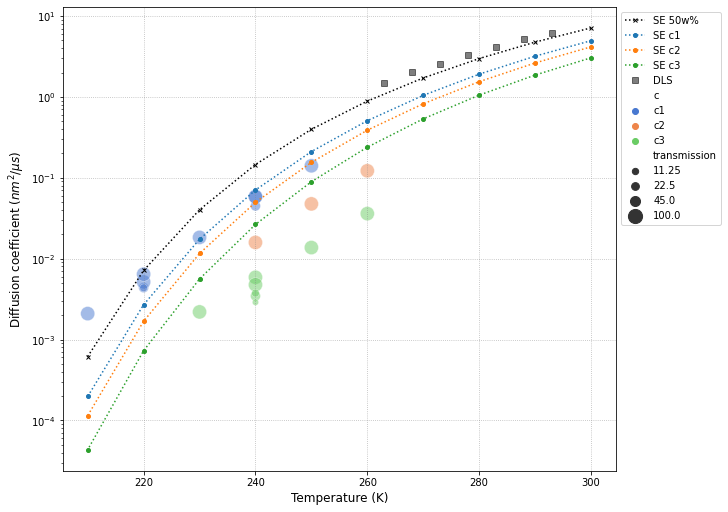

In [22]:
fig, ax = plt.subplots(1,1, figsize=(10,7), constrained_layout=True)
ax.plot(SE['temperature'], SE2['D_50w']*1e12, label='SE 50w%', c='k', marker='x', ms=4, ls=':')
# ax.plot(SE['temperature'], SE['D_50']*1e12, label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(SE['temperature'], SE['D_60']*1e12, label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
ax.plot(SE['temperature'], SE['D_c1']*1e12, label='SE c1', c='C0', marker='o', ms=4, ls=':')
ax.plot(SE['temperature'], SE['D_c2']*1e12, label='SE c2', c='C1', marker='o', ms=4, ls=':')
ax.plot(SE['temperature'], SE['D_c3']*1e12, label='SE c3', c='C2', marker='o', ms=4, ls=':')

ax.plot(DLS['T'], DLS['D'], marker='s', c='k', ls='', label='DLS', alpha=.5)
sns.scatterplot(data=df2, x='temperature', y='D', hue='c', alpha=.5, size='transmission',sizes=(40, 200), palette="muted", ax=ax)

ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel('Temperature (K)', fontsize=12)
ax.set_yscale('log')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)

## Arrhenius plot

In [62]:
D_c1 = df2[(df2['c']=='c1') & (df2['transmission']==100)].sort_values(by='temperature')
D_c2 = df2[(df2['c']=='c2') & (df2['transmission']==100)].sort_values(by='temperature')
D_c3 = df2[(df2['c']=='c3') & (df2['transmission']==100)].sort_values(by='temperature')
D_c2

,temperature,transmission,D,dD,c
19,240,100.0,0.015848,0.000249,c2
18,250,100.0,0.047516,0.003283,c2
20,260,100.0,0.121895,0.002851,c2


In [63]:
SE_test = pd.DataFrame(columns=['temperature', 'D_50', 'D_60'])
Rh = 5.785e-9

for T in eta50.keys():
    row = {'temperature': T, 'D_50w': D_coeff(T=T, eta=eta50w[T],  Rh=Rh)}
    SE_test = SE_test.append(row, ignore_index=True)

Text(0.5, 0, 'T (K)')

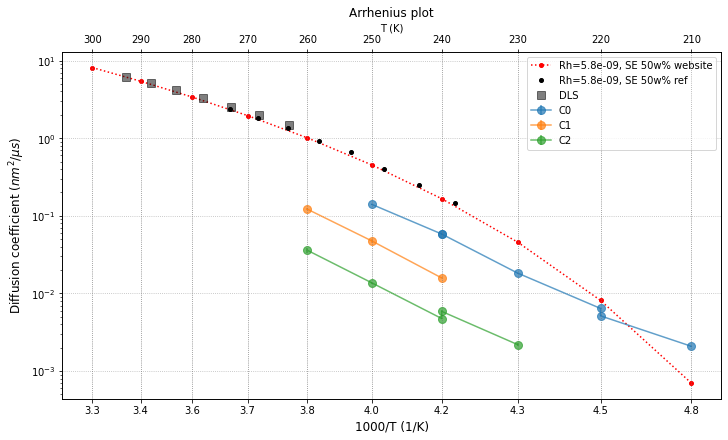

In [80]:
fig, ax = plt.subplots(1,1, figsize=(10,6), constrained_layout=True)

ax2 = ax.twiny()

scale = 1e3

# references
ax.plot(scale/SE_test['temperature'], SE_test['D_50w'], label=f'Rh={Rh:.1e}, SE 50w% website', c='r', marker='o', ms=4, ls=':') 
# ax.plot(scale/SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(scale/SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
ax.plot(scale/np.array(Tsref), Dref, marker='o', c='k', ms=4, ls='', label=f'Rh={Rh:.1e}, SE 50w% ref')
ax.plot(scale/DLS['T'], DLS['D'], marker='s', c='k', ls='', ms=8, label='DLS', alpha=.5)

# id10 data
for db, c in zip([D_c1, D_c2, D_c3], ["C0", "C1", "C2"]):
    ax.errorbar(scale/ db['temperature'],  db['D'], db['dD'], c=c, marker='o', ms=8, alpha=.7, label=c)

ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel(f'{scale:.0f}/T (1/K)', fontsize=12)
ax.set_xticks(scale/SE['temperature'].values)
ax.set_xticklabels(['%.1f' %x for x in scale/SE['temperature'].values])
ax.set_yscale('log')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)
ax.set_title('Arrhenius plot')

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/SE['temperature'].values)
ax2.set_xticklabels(["%.0f" %x for x in SE['temperature'].values])
ax2.set_xlabel('T (K)')

## Normalize curves  

**by D at 240K**

Text(0.5, 0, 'T (K)')

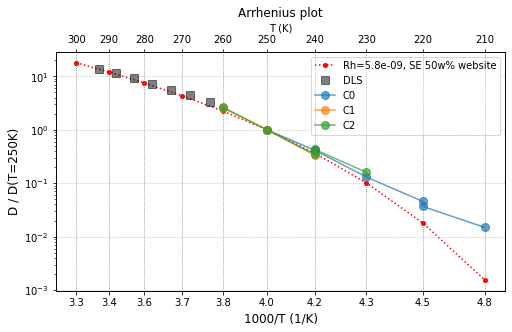

In [84]:
fig, ax = plt.subplots(1,1, figsize=(7,4.5), constrained_layout=True)

ax2 = ax.twiny()

scale, T_norm = 1e3, 250

# references
ax.plot(scale/SE_test['temperature'], SE_test['D_50w'] / SE_test.loc[SE['temperature'] == T_norm]['D_50w'].values[0], label=f'Rh={Rh:.1e}, SE 50w% website', c='r', marker='o', ms=4, ls=':') 
# ax.plot(scale/SE['temperature'], SE['D_50'] / SE.loc[SE['temperature'] == T_norm]['D_50'].values[0], label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(scale/SE['temperature'], SE['D_60']/ SE.loc[SE['temperature'] == T_norm]['D_60'].values[0], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
# ax.plot(scale/np.array(Tsref), Dref, marker='o', c='k', ms=4, ls='', label=f'Rh={Rh:.1e}, SE 50w% ref')
ax.plot(scale/DLS['T'], DLS['D'] / SE_test.loc[SE['temperature'] == T_norm]['D_50w'].values[0], marker='s', c='k', ls='', ms=8, label='DLS', alpha=.5)

for db, c in zip([D_c1, D_c2, D_c3], ["C0", "C1", "C2"]):
    temp = db['temperature'].values
    ax.plot(scale/temp,  db['D']/db.loc[db['temperature'] == T_norm]['D'].values[0], c=c, marker='o', ms=8, alpha=.7, label=c)


ax.set_ylabel(f'D / D(T={T_norm:.0f}K)', fontsize=12)
ax.set_xlabel(f'{scale:.0f}/T (1/K)', fontsize=12)
ax.set_xticks(scale/SE['temperature'].values)
ax.set_xticklabels(['%.1f' %x for x in scale/SE['temperature'].values])
ax.set_yscale('log')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)
ax.set_title('Arrhenius plot')

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/SE['temperature'].values)
ax2.set_xticklabels(["%.0f" %x for x in SE['temperature'].values])
ax2.set_xlabel('T (K)')

**by D at each temperature**

Text(0.5, 0, 'T (K)')

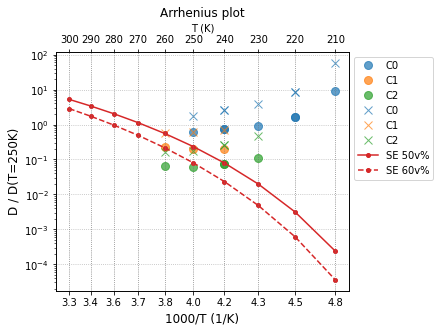

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4.5), constrained_layout=True)
ax2 = ax.twiny()
scale = 1e3

for db, c in zip([D_c1, D_c2, D_c3], ["C0", "C1", "C2"]):
    ys = []
    for t in db['temperature'].values:    
        y = db.loc[db['temperature']==t]['D'].values[0]
        norm = SE.loc[SE['temperature'] == t]['D_50'].values[0]
        ys.append(y/norm)
    ax.plot(scale/db['temperature'].values, ys, ls='', c=c, marker='o', ms=8, alpha=.7, label=c)


for db, c in zip([D_c1, D_c2, D_c3], ["C0", "C1", "C2"]):
    ys = []
    for t in db['temperature'].values:    
        y = db.loc[db['temperature']==t]['D'].values[0]
        norm = SE.loc[SE['temperature'] == t]['D_60'].values[0]
        ys.append(y/norm)
    ax.plot(scale/db['temperature'].values, ys, ls='', c=c, marker='x', ms=8, alpha=.7, label=c)

ax.plot(scale/SE['temperature'], SE['D_50'], c='C3', marker='o', ms=4, label='SE 50v%')
ax.plot(scale/SE['temperature'], SE['D_60'], c='C3', marker='o', ms=4, ls='--', label='SE 60v%',)


ax.set_ylabel(f'D / D(T={T_norm:.0f}K)', fontsize=12)
ax.set_xlabel(f'{scale:.0f}/T (1/K)', fontsize=12)
ax.set_xticks(scale/SE['temperature'].values)
ax.set_xticklabels(['%.1f' %x for x in scale/SE['temperature'].values])
ax.set_yscale('log')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)
ax.set_title('Arrhenius plot')

ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(scale/SE['temperature'].values)
ax2.set_xticklabels(["%.0f" %x for x in SE['temperature'].values])
ax2.set_xlabel('T (K)')

# DLS data 

In [ ]:
from scipy import interpolate

In [ ]:
for T in eta_50w_ref.keys():
    print(T)

273.15
268.15
263.15
258.15
253.15
248.15
243.15
238.15


In [ ]:
eta_50w_ref

{273.15: 14.6,
 268.15: 18.8,
 263.15: 24.4,
 258.15: 36.0,
 253.15: 48.1,
 248.15: 78.6,
 243.15: 123,
 238.15: 203}

In [ ]:
Rh = 5.785e-9
Tsref, Dref = [], []

for T in eta_50w_ref.keys():
    Tsref.append(T)
    print(T, eta_50w_ref[T])
    Dref.append(D_coeff(T=T, eta=eta_50w_ref[T]*1e-3, Rh=Rh))
Dref

273.15 14.6
268.15 18.8
263.15 24.4
258.15 36.0
253.15 48.1
248.15 78.6
243.15 123
238.15 203


[2.368793187496658,
 1.8059210006810889,
 1.3655020118097436,
 0.9079217600975276,
 0.6663641920761801,
 0.3997334849137091,
 0.250292570646917,
 0.14853655401440422]

Text(0, 0.5, 'D ($nm^2/\\mu s$)')

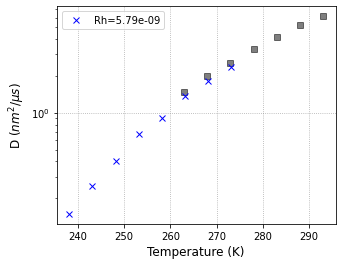

In [ ]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(DLS['T'], DLS['D'], ls='', marker='s', c='k', alpha=.5)
ax.plot(Tsref, Dref, ls='', marker='x', c='b', label=f'Rh={Rh:.2e}')

ax.legend()
ax.set_yscale('log')
ax.set_xlabel('Temperature (K)', fontsize=12)
ax.set_ylabel('D ($nm^2/\mu s$)', fontsize=12)

In [ ]:
# form dx.doi.org/10.1021/je101164q |J. Chem. Eng. Data 2011, 56, 1397–1406 in mPa*s
eta_50w_ref = {273.15: 14.6, 268.15: 18.8, 263.15: 24.4, 258.15: 36.0, 253.15: 48.1, 248.15: 78.6, 243.15: 123, 238.15: 203}

Text(0, 0.5, 'D ($nm^2/\\mu s$)')

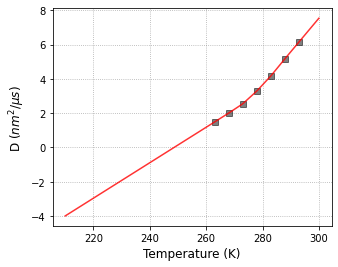

In [ ]:
x = DLS['T']
y = DLS['D']
# f = interpolate.interp1d(x, y)
f = interpolate.interp1d(x, y, fill_value='extrapolate')

xnew = np.linspace(np.min(DLS['T']), np.max(DLS['T']), 100)
xnew = np.linspace(210, 300, 100)
ynew = f(xnew)

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(DLS['T'], DLS['D'], ls='', marker='s', c='k', alpha=.5)
ax.plot(xnew, ynew, ls='-', c='r', alpha=.8)
ax.set_xlabel('Temperature (K)', fontsize=12)
ax.set_ylabel('D ($nm^2/\mu s$)', fontsize=12)


# D vs concentration (from ID10)

**Selected temperature**

In [ ]:
T_sel = 240

df2[df2['temperature']==T_sel].sort_values(by='c')

,temperature,transmission,D,dD,c
10,240,100.00,0.058330,0.002202,c1
0,240,45.00,0.044803,0.000973,c1
1,240,100.00,0.058330,0.002202,c1
19,240,100.00,0.015848,0.000249,c2
16,240,100.00,0.005881,0.000173,c3
5,240,100.00,0.004758,0.000055,c3
6,240,45.00,0.003454,0.000134,c3
7,240,22.50,0.003750,0.000246,c3
8,240,11.25,0.002887,0.000091,c3


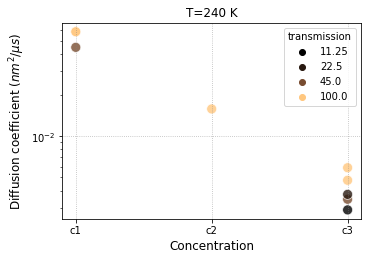

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,3.5), constrained_layout=True)
# ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
data = df2[df2['temperature']==T_sel].sort_values(by='c')

sns.scatterplot(data=data, x='c', y='D', hue='transmission', s=100,alpha=.8, ax=ax, palette="copper")
# D_concentrations = df2.sort_values(by='c')

# sns.lineplot(data=SE, x='temperature', y='D_50', palette='spring', markers=True, ax=ax)
# sns.lineplot(data=SE, x='temperature', y='D_60', markers=True, ax=ax)
# plt.legend(labels=['a', 'b', 'c'])
# sns.lineplot(data=pd.melt(SE, ['temperature']), x='temperature', y='value', palette='pink')
ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel('Concentration', fontsize=12)
ax.set_yscale('log')
ax.set_title(f'T={T_sel} K')
# ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)

**Selected transmission**

In [ ]:
Tr_sel = 100
df2[df2['transmission']==Tr_sel].sort_values(by='c')

,temperature,transmission,D,dD,c
10,240,100.0,0.058330,0.002202,c1
11,230,100.0,0.018305,0.000290,c1
2,220,100.0,0.005152,0.000091,c1
9,250,100.0,0.140541,0.003009,c1
1,240,100.0,0.058330,0.002202,c1
13,210,100.0,0.002091,0.000042,c1
12,220,100.0,0.006419,0.000093,c1
20,260,100.0,0.121895,0.002851,c2
18,250,100.0,0.047516,0.003283,c2
19,240,100.0,0.015848,0.000249,c2


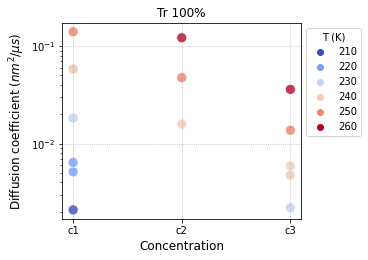

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,3.5), constrained_layout=True)
# ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
data = df2[df2['transmission']==Tr_sel].sort_values(by='c')

sns.scatterplot(data=data, x='c', y='D', hue='temperature', s=100,alpha=.8, ax=ax, palette="coolwarm")

ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel('Concentration', fontsize=12)
ax.set_yscale('log')
ax.set_title(f'Tr {Tr_sel}%')
ax.legend(bbox_to_anchor=[1,1], title='T (K)')
ax.grid(ls=':', c='gray', alpha=.6)

**D vs Transmission**

In [ ]:
T_sel = 240
df2[df2['temperature']==T_sel].sort_values(by='c')

,temperature,transmission,D,dD,c
10,240,100.00,0.058330,0.002202,c1
0,240,45.00,0.044803,0.000973,c1
1,240,100.00,0.058330,0.002202,c1
19,240,100.00,0.015848,0.000249,c2
16,240,100.00,0.005881,0.000173,c3
5,240,100.00,0.004758,0.000055,c3
6,240,45.00,0.003454,0.000134,c3
7,240,22.50,0.003750,0.000246,c3
8,240,11.25,0.002887,0.000091,c3


In [ ]:
SE

,temperature,D_50,D_60,D_50w
0,300.0,5.237051,2.847789,3.561412
1,290.0,3.388901,1.729749,2.376410
2,280.0,2.044741,0.968367,1.487076
3,270.0,1.127404,0.488342,0.856608
4,260.0,0.553158,0.215331,0.443027
5,250.0,0.232484,0.079595,0.198488
6,240.0,0.078990,0.023163,0.072896
7,230.0,0.019798,0.004816,0.020092
8,220.0,0.003136,0.000610,0.003573
9,210.0,0.000236,0.000035,0.000308


In [ ]:
SE[SE['temperature']==240]['D_50']

6    0.07899
Name: D_50, dtype: float64

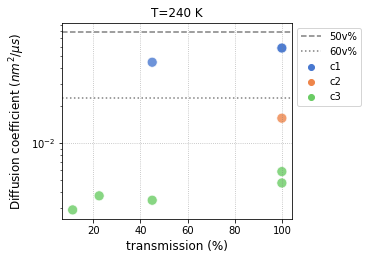

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,3.5), constrained_layout=True)
# ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)
# ax.plot(SE['temperature'], SE['D_60'], label='SE 60v%', c='C3', marker='o', ms=4, ls='--')
data = df2[df2['temperature']==T_sel].sort_values(by='c')



ax.axhline(y=SE[SE['temperature']==T_sel]['D_50'].values[0], label='50v%', ls='--', c='gray')
ax.axhline(y=SE[SE['temperature']==T_sel]['D_60'].values[0], label='60v%', ls=':', c='gray')
# ax.plot(SE['temperature'], SE['D_50'], label='SE 50v%', c='C3', marker='o', ms=4)

sns.scatterplot(data=data, x='transmission', y='D', hue='c', s=100,alpha=.8, ax=ax, palette="muted")
# D_concentrations = df2.sort_values(by='c')
ax.set_ylabel('Diffusion coefficient ($nm^2/\mu s$)', fontsize=12)
ax.set_xlabel('transmission (%)', fontsize=12)
ax.set_yscale('log')
ax.set_title(f'T={T_sel} K')
ax.legend(bbox_to_anchor=[1,1])
ax.grid(ls=':', c='gray', alpha=.6)

# DLS data interpolation

Text(0, 0.5, 'D ($nm^2/\\mu s$)')

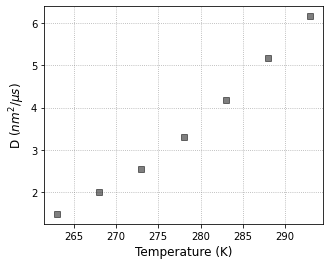